In [ ]:
!pip install pybaseball
from pybaseball import statcast, statcast_sprint_speed, statcast_fielding

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.5/416.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 41.3 MB/s eta 0:00:00


In [ ]:
!pip install nashpy
import nashpy as nash

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from datetime import timedelta, datetime
import re
import ast, numbers
import string
import cvxpy as cp
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product



In [2]:
RE_matrix = {
    0: {
        '000': .499,
        '100': .888,
        '010': 1.128,
        '001': 1.368,
        '110': 1.482,
        '011': 1.990,
        '101': 1.792
        },
    1: {
         '000': .266,
        '100': .526,
        '010': .689,
        '001': .968,
        '110': .923,
        '011': 1.409,
        '101': 1.591
    },
    2: {
         '000': .102,
        '100': .227,
        '010': .327,
        '001': .369,
        '110': .443,
        '011': .590,
        '101': .498
    },
    3: {
        '000': 0.0,
        '100': 0.0,
        '010': 0.0,
        '001': 0.0,
        '110': 0.0,
        '011': 0.0,
        '101': 0.0
    }
}

In [1]:
def encode_base_state(row):
    return ''.join(
        '1' if pd.notna(row.get(col)) else '0'
        for col in ['on_1b','on_2b','on_3b']
    )

def get_re(outs, base_state, RE_matrix):
    return RE_matrix.get(outs, {}).get(base_state, 0.0)

def convert_statcast_to_feet(x, y):
    scale = 2.5
    return (x - 125.42) * scale, (204 - y) * scale


def get_safe_prob(throw_distance, runner_speed, arm_strength):
    z = (
        -8.230604126076829
        + (-0.240074) * arm_strength
        + 0.457104   * runner_speed
        + 0.069528   * throw_distance
    )
    return 1.0 / (1.0 + np.exp(-z))

def get_arm_strength(pid, arm_df):
    try:
        return float(
            arm_df.loc[arm_df.player_id==pid, 'max_arm_strength']
                  .values[0]
        )
    except:
        return np.nan

def get_runner_speed(pid, speed_df):
    try:
        return float(
            speed_df.loc[speed_df.player_id==pid, 'sprint_speed']
                    .values[0]
        )
    except:
        return np.nan

def match_dates(retro_date):
    # retro_date format: 'BAL202204110'
    match = re.search(r'(\d{4})(\d{2})(\d{2})', retro_date)
    if match:
        # Parse date string from matched groups
        return datetime.strptime(match.group(0), "%Y%m%d").strftime("%Y-%m-%d")
    return None

def _ensure_list_of_ints(x):
    # already a list-like of ints
    if isinstance(x, list) and all(isinstance(v, numbers.Integral) for v in x):
        return x
    # missing
    if pd.isna(x):
        return []
    # if it's a string, try to parse a Python literal like "[1, 3]"
    if isinstance(x, str):
        s = x.strip()
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple)) and all(isinstance(v, numbers.Integral) for v in val):
                return [int(v) for v in val]
            # sometimes it's like "1 3" or "1,3" etc. fall through to regex
        except Exception:
            pass
        # fallback: extract digits/groups of digits
        tokens = re.findall(r'\d+', s)
        return [int(t) for t in tokens]
    # single numeric values (np.int64, float, etc.)
    if isinstance(x, numbers.Integral):
        return [int(x)]
    try:
        # attempt to coerce iterables (e.g., numpy arrays, tuples)
        seq = list(x)
        if all(isinstance(v, numbers.Integral) for v in seq):
            return [int(v) for v in seq]
    except Exception:
        pass
    # last resort
    return []
def load_chadwick_id_map():

    suffixes = [str(i) for i in range(1, 10)] + list(string.ascii_lowercase[:6])

# Construct file paths
    file_paths = [f"/content/people-{s}.csv" for s in suffixes]

# Read and combine them all into a single DataFrame
    people_dfs = []
    for path in file_paths:
        try:
            df = pd.read_csv(path, low_memory=False, on_bad_lines='skip')
            people_dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: File not found at {path}")
            continue

    combined = pd.concat(people_dfs).drop_duplicates(subset='key_retro')
    combined = combined.dropna(subset=['key_retro', 'key_mlbam'])
    combined['key_retro'] = combined['key_retro'].astype(str)
    combined['key_mlbam'] = combined['key_mlbam'].astype(str)
    return dict(zip(combined['key_retro'], combined['key_mlbam']))


def process_combined_tagup_data(
    retrosheet_df,
    savant_df,
    simulation_df,
    arm,
    speed
):
    # Step 1: prepare ID and date mapping
    id_map = load_chadwick_id_map()
    retrosheet_df = retrosheet_df.copy()
    retrosheet_df['mlbam_id'] = retrosheet_df['batter_id'].map(id_map)
    retrosheet_df['parsed_date'] = retrosheet_df['game_id'].apply(match_dates)

    # Step 2: filter savant for relevant plays
    savant_df = savant_df.copy()
    savant_df = savant_df[savant_df.hit_location.notna()]
    savant_df = savant_df[savant_df['events'].isin(['sac_fly', 'field_out', 'double_play'])]
    savant_df['base_state'] = savant_df.apply(encode_base_state, axis=1)
    savant_df['occupied'] = savant_df['base_state'].str.count('1')
    savant_df = savant_df[savant_df['occupied'] == 2]
    retrosheet_df['mlbam_id'] = retrosheet_df['mlbam_id'].astype(str)
    savant_df['batter'] = savant_df['batter'].astype(str)
    savant_df['fielder_id'] = savant_df.apply(
        lambda r: r.get(f"fielder_{int(r.hit_location)}", np.nan), axis=1
    )
    # Step 3: match savant to retrosheet
    retrosheet_df['mlbam_id'] = retrosheet_df['mlbam_id'].astype(str)
    retrosheet_df['parsed_date'] = retrosheet_df['parsed_date'].astype(str)

    savant_df['batter'] = savant_df['batter'].astype(str)
    savant_df['game_date'] = savant_df['game_date'].astype(str)


    ids = pd.to_numeric(retrosheet_df['mlbam_id'], errors='coerce')


    ids = ids.replace([np.inf, -np.inf], np.nan)


    ids_clean = ids.dropna()

#convert to int then string
    retrosheet_df['mlbam_id'] = ids_clean.astype(int).astype(str)
    # Fix mlbam_id in retrosheet_df
    retrosheet_df['mlbam_id'] = (
      retrosheet_df['mlbam_id']
      .dropna()
      .astype(float)  # in case it's been inferred as object
      .astype(int)    # remove the .0
      .astype(str)    # now convert to string
    )

# Also make sure batter column in savant_df is string
    savant_df['batter'] = savant_df['batter'].astype(str).str.strip()

    # We're joining rows where the batter (mlbam_id) and inning and game date match.
    merged = pd.merge(
        retrosheet_df,
        savant_df,
        left_on=['mlbam_id', 'parsed_date', 'inning'],
        right_on=['batter', 'game_date', 'inning'],
        how='inner',
        indicator= True,
        suffixes=('_retro', '_sv')
    )
    merged['arm_strength'] = merged['fielder_id'].apply(
      lambda pid: get_arm_strength(pid, arm)
    )

# Get speeds for all potential runners
    merged['speed_1b'] = merged['on_1b'].apply(
      lambda pid: get_runner_speed(pid, speed) if pd.notna(pid) else None
    )
    merged['speed_2b'] = merged['on_2b'].apply(
      lambda pid: get_runner_speed(pid, speed) if pd.notna(pid) else None
    )
    merged['speed_3b'] = merged['on_3b'].apply(
      lambda pid: get_runner_speed(pid, speed) if pd.notna(pid) else None
    )

    merged = merged.dropna(subset=['arm_strength'])

# Step 5: calculate safe probabilities
    BASE_COORDS = {2:(0,126), 3:(-63,63), 4:(0,0)}

    def calc_sps(r):
      x_ft, y_ft = convert_statcast_to_feet(r.hc_x, r.hc_y)
      occ = [i+2 for i,c in enumerate(['on_1b','on_2b','on_3b'])
            if pd.notna(r[c])]
      ds = []
      runner_speeds = []

      for base in occ:
        bx, by = BASE_COORDS[base]
        ds.append(np.hypot(x_ft-bx, y_ft-by))

        # Get the correct runner's speed for this base
        if base == 2:  # Runner on 1st going to 2nd
            runner_speeds.append(r.speed_1b)
        elif base == 3:  # Runner on 2nd going to 3rd
            runner_speeds.append(r.speed_2b)
        elif base == 4:  # Runner on 3rd going home
            runner_speeds.append(r.speed_3b)

    # Only calculate probabilities if we have the runner speeds
      sp1 = get_safe_prob(ds[0], runner_speeds[0], r.arm_strength) if pd.notna(runner_speeds[0]) else None
      sp2 = get_safe_prob(ds[1], runner_speeds[1], r.arm_strength) if len(ds) > 1 and pd.notna(runner_speeds[1]) else None

      return pd.Series({'sp1': sp1, 'sp2': sp2})

    merged[['sp1','sp2']] = merged.apply(calc_sps, axis=1)
    merged = merged.dropna(subset=['sp1', 'sp2'])
# Drop rows where we couldn't calculate probabilities due to missing data

    # Step 6: compute run expectancy and strategy payoff
    merged['bases_key'] = merged['base_state_sv'].apply(
    lambda bs: '[' + ', '.join(str(i+1) for i,ch in enumerate(bs) if ch=='1') + ']'
    )
    merged['chosen_strategy_payoff'] = merged['delta_run_exp_retro']
    # 7d) prepare sim table subset for merge
    model_df = (
        simulation_df
        .rename(columns={
            'runner_eq': 'model_optimal_strategy',
            'payoff':    'model_optimal_payoff'
        })[['outs','bases','sp1','sp2','model_optimal_strategy','model_optimal_payoff']]
        .copy()
    )
    # 7b) nearest‐(sp1,sp2) lookup, matching on outs_retro + bases_key
    def match_model(r):
    # Extract observed safe percentages
      p1_obs = r['sp1']
      p2_obs = r['sp2']



    # Filter model table for matching state
      mask_outs  = model_df['outs']  == r['outs'] + 1
      mask_bases = model_df['bases'] == r['bases_key']
      sub = model_df[mask_outs & mask_bases]

      if sub.empty:
        return pd.Series({
            'model_optimal_strategy': np.nan,
            'model_optimal_payoff':   np.nan
        })

    # Match based on (p1_raw, p2_raw)
      d    = np.hypot(sub['sp1'] - p1_obs, sub['sp2'] - p2_obs)
      best = sub.iloc[d.argmin()]
      return pd.Series({
        'model_optimal_strategy': best['model_optimal_strategy'],
        'model_optimal_payoff':   best['model_optimal_payoff']
      })

# Apply matching
    merged[['model_optimal_strategy', 'model_optimal_payoff']] = (
      merged.apply(match_model, axis=1)
    )
    merged["chosen_runner_strategy"] = merged["chosen_runner_strategy"].apply(_ensure_list_of_ints)

    merged["eq_runner"] = merged.apply(lambda r: classify_fielder_action(r, RE_matrix)[1], axis=1)

    merged["delta"] = merged.apply(
    lambda r: classify_fielder_action(r, RE_matrix)[2], axis=1
    )
    # Step 8: compute payoff difference and finalize
    merged['payoff_diff'] = (
        merged['chosen_strategy_payoff'] - merged['model_optimal_payoff']
    )
    # after you’ve done your original merge + computed chosen_strategy_payoff…

    merged['throw_class'] = merged.apply(
    lambda r: classify_fielder_action(r, RE_matrix)[0], axis=1
    )
    vals = pd.to_numeric(merged['throw_class'].replace('', np.nan), errors='coerce')

    total = vals.notna().sum()
    if total == 0:
      print("No labeled rows (0/1/2) found.")
    else:
      for k in [0, 1, 2]:
        pct = (vals == k).sum() / total * 100
        print(f"{pct:.2f}% {k}")

    # Summarize



    payoff_sum_by_team = merged.groupby('teamname')['payoff_diff'].sum()
    payoff_sum = merged['payoff_diff'].sum()
    print(payoff_sum, "sum")
    print(payoff_sum_by_team)
    # Step 8: final output

    eq_runner_did_not_go = 0
    total_rows = 0

    for _, row in merged.iterrows():
    # Decode which runner(s) tagged
    #tagged bases needs to be list of advanced runners, in base #
      tagged_bases = row['chosen_runner_strategy']
    # Only consider plays with two runners (trailing and leading)
      state = [i+1 for i,ch in enumerate(row['base_state_sv']) if ch=='1']
      if len(state) != 2:
        continue

      trailing, leading = state[0], state[1]

    # Identify eq runner
      eq_runner = row['eq_runner']  # 1=trailing, 2=leading

    # Check if eq runner did NOT go
      if eq_runner == 1 and trailing not in tagged_bases:
        eq_runner_did_not_go += 1
      elif eq_runner == 2 and leading not in tagged_bases:
        eq_runner_did_not_go += 1

      total_rows += 1

# Print percentage
    if total_rows > 0:
      pct = eq_runner_did_not_go / total_rows * 100
      print(f"EQ runner did NOT go {pct:.2f}% of the time ({eq_runner_did_not_go}/{total_rows})")
    else:
      print("No rows with two runners found.")

    merged["sp_eq"] = merged.apply(lambda row: row["sp1"] if row["eq_runner"] == 1 else row["sp2"], axis=1)
    merged["sp_non_eq"] = merged.apply(lambda row: row["sp1"] if row["eq_runner"] == 2 else row["sp2"], axis=1)
    print(merged["sp_eq"].describe())

    em = em_pi_zeros(merged["throw_class"], merged["sp_eq"], merged["sp_non_eq"])
    print(em)


# Analyze results and calculate total proportion incorrect
    merged['chosen_runner_strategy'] = merged['chosen_runner_strategy'].astype(str)
    merged['model_optimal_strategy'] = merged['model_optimal_strategy'].astype(str)
    mismatch =  merged['chosen_runner_strategy'] != merged['model_optimal_strategy']
    print(merged["chosen_runner_strategy"], merged['model_optimal_strategy'])
    num_mis = mismatch.sum()
    pct_mis = num_mis / len(merged) * 100
    print(f"{pct_mis:.2f}% mismatched")
    payoff_mis = merged.loc[mismatch, 'payoff_diff'].sum()
    print(f"Total payoff difference mismatched: {payoff_mis}")
    print(merged[[
        'teamname',
        'outs',
        'base_state_retro',
        'chosen_runner_strategy',
        'model_optimal_strategy',
        'chosen_strategy_payoff',
        'model_optimal_payoff',
        'payoff_diff',
        'sp1','sp2',
        'speed_1b', 'speed_2b', 'speed_3b','arm_strength'
    ]])
    return merged[[
        'teamname',
        'outs',
        'base_state_retro',
        'chosen_runner_strategy',
        'model_optimal_strategy',
        'chosen_strategy_payoff',
        'model_optimal_payoff',
        'payoff_diff',
        'sp1','sp2',
        'speed_1b', 'speed_2b', 'speed_3b','arm_strength'
    ]]

In [3]:
def get_RE(state, outs):
    key = ''.join(str(int(i in state)) for i in [1, 2, 3])
    return RE_matrix[outs].get(key, 0.0)
# --- Existing helper apply_strategy assumed imported above ---
def apply_strategy(runner_strat, fielder_choice, state, outs, success):
    new_state   = set(state)
    new_outs    = outs
    runs_scored = 0

    # Determine indices: leading = last in state list, trailing = first
    # e.g. state=[1,3] -> trailing_idx=0, leading_idx=1
    idxs = list(range(len(state)))
    # Process the leading runner first
    if len(idxs) == 2:
        process_order = [idxs[1], idxs[0]]
    else:
        process_order = idxs

    for idx in process_order:
        will_tag = runner_strat[idx]
        if not will_tag:
            continue

        base = state[idx]
        tgt  = base + 1

        if fielder_choice == tgt:
            new_state.discard(base)
            if success:
                if tgt == 4:
                    runs_scored += 1
                else:
                    new_state.add(tgt)
            else:
                new_outs += 1
        else:
            new_state.discard(base)
            if tgt == 4:
                runs_scored += 1
            else:
                new_state.add(tgt)

    return list(new_state), new_outs, runs_scored

def decode_and_filter_strategy(chosen_strat: str, base_state: str):
    vec = [int(float(x)) for x in chosen_strat.strip("[]").split()]
    try:
        idx = vec.index(1)
    except ValueError:
        return []
    bs = base_state
    if bs == '101':
        mapping = {0: [], 1: [3], 2: [1], 3: [1,3]}
    elif bs == '011':
        mapping = {0: [2], 1: [3], 2: [2,3]}
    elif bs == '110':
        mapping = {0: [1], 1: [2], 2: [1,2]}
    else:
        return []
    return mapping.get(idx, [])

def classify(adv, org, new_base_state_str, eq_runner_position, success):
  #org "xxx"
  #exp "xxxx"- add home
  #adv [x, x]--base number
  #eq_runner_position 1 or 2 (trailing or leading)
  #pos_list [x, x]--index of trailing runner, leading runner in org
  #eq_index is the base of eq runner
  exp = org+"0"
  exp = list(exp)
  if success == "True":
    new_base_state_str = new_base_state_str+"1"
  else:
    new_base_state_str = new_base_state_str+"0"
  eq_index = 0
  pos_list = [0, 0]
  n = 0
  for adv_base in sorted(adv, reverse = True):#so that runners are not deleted
      exp[adv_base] = "1"
      exp[adv_base-1] = "0"
  exp = "".join(exp)
  for idx, i in enumerate([org[0], org[1], org[2]]):
    if i == "1":
      pos_list[n] = idx
      n += 1
  if eq_runner_position == 1:
    eq_index = pos_list[0]+1
    non_eq_index = pos_list[1]+1
  else:
    eq_index = pos_list[1]+1
    non_eq_index = pos_list[0]+1
  for i in range(len(exp)):
    if exp[i] != new_base_state_str[i]:
      if i == (eq_index):
        return 2
      elif i == (non_eq_index):
        return 1
  if eq_index in adv:
    return 0
  elif non_eq_index in adv:
    return 4
  return 3



def classify_fielder_action(row, RE_matrix, tol=1e-6):
    """
    Simulate deterministic outcomes for the OBSERVED chosen runner strategy,
    compare realized payoffs to row['chosen_strategy_payoff'], and return:
      (label, eq_runner_base, delta)
        label: ""  -> skipped (single-runner/no-tag)
               0   -> eq safe (no runner thrown out)
               1   -> non-EQ runner thrown out
               2   -> EQ runner thrown out
               4 ->   non eq safe (no runner thrown out), eq runner holds
        eq_runner_base: base number (1/2/3) that game-theory says is EQ target (or None)
        delta: runner NE payoff vs NE fielder - runner NE payoff vs other fielder
    """
    # 1) decode which runner(s) tagged
    adv = row['chosen_runner_strategy']
    if not adv:
        return ("", None, None)  # skip single-runner or no-tag

    # 2) build state and runner_strats (two-runner logic)
    state = eval(row['bases_key'])
    raw = list(itertools.product([0, 1], repeat=2))
    runner_strats = [rs for rs in raw if not (rs == (1, 0) and state != [1, 3])]
    R = len(runner_strats)

    outs = int(row['outs']) + 1
    sp1, sp2 = float(row['sp1']), float(row['sp2'])

    base0_key = ''.join('1' if b in state else '0' for b in [1, 2, 3])
    RE0 = RE_matrix.get(outs, {}).get(base0_key, 0.0)

    fielder_choices = [b + 1 for b in state]
    N = len(fielder_choices)
    payoff = np.zeros((R, N))

    for i, rs in enumerate(runner_strats):
        for j, fc in enumerate(fielder_choices):
            if sum(rs) == 0:
                exp_RE = RE0
            else:
                if fc == state[0] + 1 and rs[0]:
                    sp = sp1
                elif len(state) > 1 and fc == state[1] + 1 and rs[1]:
                    sp = sp2
                else:
                    sp = 1.0
                s_key, s_o, s_r = apply_strategy(rs, fc, state, outs, True)
                f_key, f_o, f_r = apply_strategy(rs, fc, state, outs, False)
                REs = s_r + get_RE(s_key, s_o)
                REf = f_r + get_RE(f_key, f_o)
                exp_RE = sp * REs + (1 - sp) * REf
            payoff[i, j] = exp_RE - RE0
            if np.isnan(payoff[i, j]):
              print(sp, "sp")
              print(REs, "res")
              print(REf, "ref")
              print(exp_RE, "exp")
              print(RE0, "re0")

    # --- Solve for runner NE ---

    c = np.concatenate([np.zeros(R), [-1]])
    A_ub = np.column_stack([-payoff.T, np.ones(N)])
    b_ub = np.zeros(N)
    A_eq = np.concatenate([np.ones(R), [0]]).reshape(1, -1)
    b_eq = np.array([1])

    bounds = [(0, None)] * R + [(None, None)]
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if not res.success:
        eq_idx = None
        eq_runner_base = None
        delta = None
    else:
        p_runner = res.x[:R]
        eq_idx = int(np.argmax(p_runner))


        # --- Solve for fielder NE ---
        c_f = np.concatenate([np.zeros(N), [1.0]])
        A_ub_f = np.column_stack([payoff, -np.ones(R)])
        b_ub_f = np.zeros(R)
        A_eq_f = np.concatenate([np.ones(N), [0]]).reshape(1, -1)
        b_eq_f = np.array([1])
        bounds_f = [(0, None)] * N + [(None, None)]
        res_f = linprog(c_f, A_ub=A_ub_f, b_ub=b_ub_f, A_eq=A_eq_f, b_eq=b_eq_f, bounds=bounds_f, method='highs')
        if res_f.success:
            p_fielder = res_f.x[:N]
        else:
            print("Fielder solve failed")
            p_fielder = np.ones(N) / N

        j_eq = int(np.argmax(p_fielder))
        fielder_target_base = fielder_choices[j_eq]
        if fielder_target_base == state[0] + 1:
            eq_runner_base = state[0]
        elif len(state) > 1 and fielder_target_base == state[1] + 1:
            eq_runner_base = state[1]
        else:
            eq_runner_base = None
        # Map eq_runner_base to trailing (1) or leading (2) runner
        if eq_runner_base is not None:
          if len(state) == 2:
        # Identify trailing and leading
            trailing, leading = state[0], state[1]
            if eq_runner_base == trailing:
              eq_runner_position = 1
            elif eq_runner_base == leading:
              eq_runner_position = 2
            else:
              eq_runner_position = None
          else:
        # Only one runner, assign 1 (trailing)
            eq_runner_position = 1
        else:
          eq_runner_position = None

        # --- Compute delta ---
        payoff_vs_NEfielder = np.dot(payoff[eq_idx, :], p_fielder)
        other_fielder_idx = 1 - j_eq if N == 2 else None
        if other_fielder_idx is not None:
            payoff_vs_otherfielder = payoff[eq_idx, other_fielder_idx]
            delta = payoff_vs_NEfielder - payoff_vs_otherfielder
        else:
            delta = None
    # Compute % of time non-EQ runners choose to go

    # 4) Match observed play
    chosen_tuple = tuple(1 if b in adv else 0 for b in state)
    obs_payoff = float(row['chosen_strategy_payoff'])


    new_base_state_str = str(row["next_base_state"]).zfill(3)
    tagup_success = str(row["tagup_success"])

    throw_class = classify(adv, base0_key, new_base_state_str, eq_runner_position, tagup_success)
    return throw_class, eq_runner_position, delta





In [4]:

def em_pi_zeros(U, p_safe, non_eq_safe, tol=1e-8, max_iter=1000, verbose=True):
    """
    EM algorithm to estimate pi (fraction of throws to non-eq runner).

    Baseball context:
    - Incorrect throw = throw to non-eq runner
    - Correct throw = throw to eq runner
    - U=0: safe advance of eq runner
    - U=1: out advance of non-eq runner
    - U=2: out advance of eq runner
    - U=4: safe advance of non-eq runner

    Given constraint relationships:
    - pi = p(throw to non-eq runner)
    - p(throw to non-eq | U=0) = 1 - (p_safe * (1-pi))
    - p(throw to non-eq | U=1) = 1
    - p(throw to non-eq | U=2) = 0
    - p(throw to non-eq | U=4) = 1 - (p_safe * pi)
    """
    U = np.array(U)
    p_safe = np.array(p_safe)
    non_eq_safe = np.array(non_eq_safe)

    zeros_idx = (U == 0)
    ones_idx = (U == 1)
    twos_idx = (U == 2)
    fours_idx = (U == 4)

    n0 = zeros_idx.sum()
    n1 = ones_idx.sum()
    n2 = twos_idx.sum()
    n4 = fours_idx.sum()
    N = len(U)

    print(f"N={N}, n0={n0}, n1={n1}, n2={n2}, n4={n4}")

    if N == 0:
        return {"pi": 0.0, "loglike_trace": [0.0], "iterations": 0}

    # Get p_safe values for relevant observations
    p_safe_zeros = p_safe[zeros_idx] if n0 > 0 else np.array([])
    p_safe_fours = non_eq_safe[fours_idx] if n4 > 0 else np.array([])

    # Initialize pi
    pi = 0.5
    loglike_trace = []

    for it in range(max_iter):
        # E-step: compute posteriors using your constraint relationships

        # p(throw to non-eq | U=0) = 1 - (p_safe * (1-pi))
        if n0 > 0:
            gamma_zeros = 1 - (p_safe_zeros * (1 - pi))
            gamma_zeros = np.clip(gamma_zeros, 0, 1)
        else:
            gamma_zeros = np.array([])

        # p(throw to non-eq | U=1) = 1
        gamma_ones = 1.0

        # p(throw to non-eq | U=2) = 0
        gamma_twos = 0.0

        # p(throw to non-eq | U=4) = 1 - (p_safe * pi)
        if n4 > 0:
            gamma_fours = 1 - (p_safe_fours * pi)
            gamma_fours = np.clip(gamma_fours, 0, 1)
        else:
            gamma_fours = np.array([])

        # M-step: update pi based on expected number of throws to non-eq runner
        total_expected_non_eq = 0
        total_observations = N

        # Add contributions from each outcome type
        if n0 > 0:
            total_expected_non_eq += np.sum(gamma_zeros)

        if n1 > 0:
            total_expected_non_eq += n1 * gamma_ones  # = n1

        if n2 > 0:
            total_expected_non_eq += n2 * gamma_twos  # = 0

        if n4 > 0:
            total_expected_non_eq += np.sum(gamma_fours)

        pi_new = total_expected_non_eq / total_observations

        # For log-likelihood, we need to be careful about the constraint structure
        # The relationships you gave are constraints, not generative probabilities
        # So we compute a "pseudo-likelihood" based on consistency with constraints

        ll = 0
        eps = 1e-300

        # Contribution from constraint satisfaction
        if n0 > 0:
            # How well does current pi satisfy the U=0 constraint?
            constraint_0 = 1 - (p_safe_zeros * (1 - pi_new))
            # Pseudo-likelihood: higher when constraint is better satisfied
            ll += np.sum(np.log(np.clip(constraint_0 * pi_new + (1 - constraint_0) * (1 - pi_new), eps, None)))

        if n1 > 0:
            # U=1 implies throw to non-eq runner with probability 1
            ll += n1 * np.log(np.clip(pi_new, eps, None))

        if n2 > 0:
            # U=2 implies throw to eq runner with probability 1
            ll += n2 * np.log(np.clip(1 - pi_new, eps, None))

        if n4 > 0:
            constraint_4 = 1 - (p_safe_fours * pi_new)
            ll += np.sum(np.log(np.clip(constraint_4 * pi_new + (1 - constraint_4) * (1 - pi_new), eps, None)))

        loglike_trace.append(ll)

        if verbose:
            print(f"iter {it+1:3d}: pi={pi_new:.6f}, ll={ll:.2f}")

        # Check convergence
        if it > 0 and abs(pi_new - pi) < tol:
            break

        pi = pi_new

    return {
        "pi": pi,
        "loglike_trace": loglike_trace,
        "iterations": it + 1,
        "posteriors_final": {
            "zeros": gamma_zeros if n0 > 0 else None,
            "ones": gamma_ones if n1 > 0 else None,
            "twos": gamma_twos if n2 > 0 else None,
            "fours": gamma_fours if n4 > 0 else None
        }
    }


def interpret_results(result, U, verbose=True):
    """Helper function to interpret the EM results in baseball context."""
    pi = result["pi"]

    print(f"\n=== Baseball Throw Analysis ===")
    print(f"Estimated fraction of throws to non-eq runner: {pi:.3f}")
    print(f"Estimated fraction of throws to eq runner: {1-pi:.3f}")

    if verbose:
        U = np.array(U)
        print(f"\nObserved outcomes:")
        print(f"  U=0 (safe eq advance): {np.sum(U==0)} observations")
        print(f"  U=1 (out non-eq advance): {np.sum(U==1)} observations")
        print(f"  U=2 (out eq advance): {np.sum(U==2)} observations")
        print(f"  U=4 (safe non-eq advance): {np.sum(U==4)} observations")

        print(f"\nConverged after {result['iterations']} iterations")



In [5]:
sim = pd.read_csv("two_runners_on (12).csv")
savant = pd.read_csv("two_runners_savant.csv")
retrosheet = pd.read_csv("tagup_potential (3).csv")
combined_df_arm = pd.read_csv("combined_arm_strength (2).csv")
combined_df_speed = pd.read_csv("combined_speed.csv")
merged = process_combined_tagup_data(retrosheet, savant, sim, combined_df_arm, combined_df_speed)
merged.to_csv("two_runners_tagups.csv")

/tmp/ipython-input-3238931854.py:293: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vals = pd.to_numeric(merged['throw_class'].replace('', np.nan), errors='coerce')


77.20% 0
1.23% 1
3.12% 2
-93.78184279999994 sum
teamname
ANA   -3.447602
ARI   -1.492644
ATL    0.271750
BAL   -3.641450
BOS   -6.260068
CHA   -1.344013
CHN   -6.940015
CIN   -2.821874
CLE   -6.143847
COL   -3.420754
DET   -2.594758
HOU   -3.929710
KCA   -5.829742
LAN   -7.271813
MIA   -3.032397
MIL   -3.192913
MIN   -4.976170
NYA   -3.813789
NYN   -2.166784
OAK   -0.292712
PHI   -2.799932
PIT   -1.032600
SDN   -3.789614
SEA   -5.485360
SFN   -0.203450
SLN   -1.324874
TBA   -1.233020
TEX   -1.492420
TOR   -2.732765
WAS   -1.346501
Name: payoff_diff, dtype: float64
EQ runner did NOT go 9.95% of the time (367/3687)
count    3.687000e+03
mean     6.008899e-01
std      3.819971e-01
min      2.155668e-08
25%      1.789821e-01
50%      7.514834e-01
75%      9.660011e-01
max      9.999483e-01
Name: sp_eq, dtype: float64
N=3687, n0=1507, n1=24, n2=61, n4=360
iter   1: pi=0.284457, ll=-1267.51
iter   2: pi=0.226489, ll=-1217.32
iter   3: pi=0.210900, ll=-1204.94
iter   4: pi=0.206707, ll=-1201.

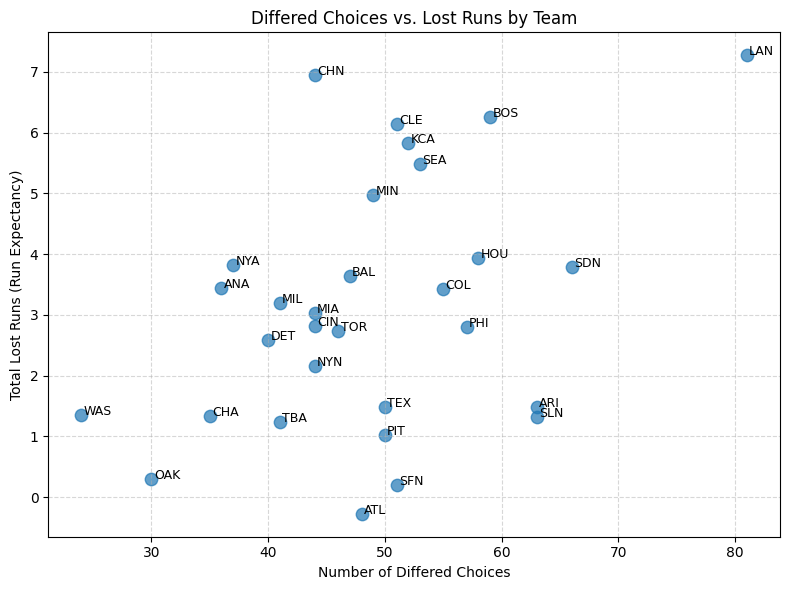

{'obs_total_loss': 111.12491079999995, 'n_mismatch': 1459, 'n_plays': 3687, 'p_value': 1.999960000799984e-05, 'count_extreme': 0, 'n_perm': 50000}


In [6]:

mismatch = merged['chosen_runner_strategy'] != merged['model_optimal_strategy']

team_summary = (
    merged.assign(mismatch=mismatch)
          .groupby("teamname")
          .agg(
              num_diff_choices=("mismatch", "sum"),
              total_lost_runs=("payoff_diff", "sum")
          )
          .reset_index()
)


plt.figure(figsize=(8,6))
plt.scatter(
    team_summary["num_diff_choices"],
    -team_summary["total_lost_runs"],
    s=80, alpha=0.7
)

for _, row in team_summary.iterrows():
    plt.text(row["num_diff_choices"]+0.2,
             -row["total_lost_runs"],
             row["teamname"], fontsize=9)

plt.xlabel("Number of Differed Choices")
plt.ylabel("Total Lost Runs (Run Expectancy)")
plt.title("Differed Choices vs. Lost Runs by Team")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


def permutation_pvalue_total_loss(merged_df, n_perm=20000, seed=0):
    rng = np.random.default_rng(seed)

    # Construct mismatch mask
    mismatch_mask = merged_df["chosen_runner_strategy"] != merged_df["model_optimal_strategy"]

    # Grab payoff values
    payoff_vals = merged_df["payoff_diff"].values

    # Observed total (loss magnitude)
    obs_total_loss = payoff_vals[mismatch_mask].sum()

    # If losses are negative, flip signs so loss magnitude is positive
    if obs_total_loss < 0:
        obs_total_loss = -obs_total_loss
        payoff_vals = -payoff_vals

    n_mismatch = mismatch_mask.sum()
    n = len(merged_df)

    count = 0
    for _ in range(n_perm):
        # randomly choose n_mismatch plays as if they were mismatches
        chosen_idx = rng.choice(n, size=n_mismatch, replace=False)
        perm_sum = payoff_vals[chosen_idx].sum()
        if perm_sum >= obs_total_loss:
            count += 1

    p_value = (count + 1) / (n_perm + 1)  # small-sample correction
    return {
        "obs_total_loss": float(obs_total_loss),
        "n_mismatch": int(n_mismatch),
        "n_plays": int(n),
        "p_value": p_value,
        "count_extreme": count,
        "n_perm": n_perm
    }

res = permutation_pvalue_total_loss(merged, n_perm=50000, seed=123)
print(res)



In [ ]:
def _tag_result_row(row):
    bs = str(row['base_state'])
    present = [i+1 for i, c in enumerate(bs) if c == '1']
    # only meaningful for two-runner situations
    if len(present) != 2:
        return [None, None]
    parts = str(row.get('event', '')).split('.', 1)
    segs = parts[1].split(';') if len(parts) > 1 else []

    res = [None, None]  # [trailing, leading]
    for idx, base in enumerate(present):  # idx 0 -> trailing, 1 -> leading
        for seg in segs:
            s = seg.strip().lower()
            m = re.search(r'(\d+)(?=[x-])', s)
            if m and int(m.group(1)) == base:
                # prefer '-' over 'x' if both appear ( '-' => 1, 'x' => 0 )
                if '-' in s:
                    res[idx] = 1
                elif 'x' in s:
                    res[idx] = 0
                break
    return res

# Base directory in Colab where CSVs are stored
base_dir = '/content/'

# Team codes and years
AL_TEAMS = ['BAL','BOS','CHA','CLE','DET','HOU','KCA','ANA','MIN','NYA','OAK','SEA','TEX','TOR','TBA']
NL_TEAMS = ['ARI','ATL','CHN','CIN','COL','LAN','MIA','MIL','NYN','PHI','PIT','SDN','SFN','SLN','WAS']
TEAMS = AL_TEAMS + NL_TEAMS
YEARS = ['2022','2023','2024']

# BEVENT output columns (fields 0,2,4,26,27,28,10,29,85,86)
col_names = [
    'game_id',
    'visit',
    'inning',
    'bat_team',
    'outs',
    'batter_id',
    'runner_1b',
    'runner_2b',
    'runner_3b',
    'event',
    'col_7', #substituion columns, just in case useful later when concat
    'col_8'
]

# Example run expectancy matrix (you should load a real one)
#re already loaded in different cell

def get_re(outs, base_state, RE_matrix):
    return RE_matrix.get(outs, {}).get(base_state, 0.0)

# List to collect filtered DataFrames
filtered_list = []

for year in YEARS:
    for team in TEAMS:
        fname = f"{team}{year}.csv"
        path = os.path.join(base_dir, fname)
        if not os.path.exists(path):
            print(f"File not found: {fname}")
            continue

        df = pd.read_csv(path, header=None, names=col_names)
        df['team_iter'] = team
        df['year'] = year
        df['outs'] = df['outs'].astype(int)
        df['inning'] = df['inning'].astype(int)
        df['bat_team'] = df['bat_team'].astype(int)

        df['base_state'] = (
           df[['runner_1b', 'runner_2b', 'runner_3b']]
          .notnull().astype(int)
          .agg(lambda row: f"{row['runner_1b']}{row['runner_2b']}{row['runner_3b']}", axis=1)
        )


        # Determine scoring based on event string
        # Update to count occurrences of (-B|-H)
        df['tagup_success'] = df['event'].astype(str).str.contains(r'(-B|-H)').map({True: "True", False: "False"})
        df['tagup_runs'] = df['event'].astype(str).str.contains(r'(-B|-H)').map({True: 1, False: 0})

        # Calculate RE0
        df['re0'] = df.apply(lambda r: get_re(r.outs+1, r.base_state, RE_matrix), axis=1)
        # Shift to get next row's RE state
        df['next_inning'] = df['inning'].shift(-1)
        df['next_bat_team'] = df['bat_team'].shift(-1)
        df['next_outs'] = df['outs'].shift(-1)
        df['next_base_state'] = df['base_state'].shift(-1)

        def compute_re1(row):
            # Inning or team change
            if row['inning'] != row['next_inning'] or row['bat_team'] != row['next_bat_team']:
                re = 0.0
                re += row['tagup_runs']
                return re
            re = get_re(row['next_outs'], row['next_base_state'], RE_matrix)
            re += row['tagup_runs']
            return re


        df['re1'] = df.apply(compute_re1, axis=1)
        df['delta_run_exp'] = df['re1'] - df['re0']

        def strategy(row):
            results = []
            bs = row.base_state
            # Identify present runners
            present = [i+1 for i, c in enumerate(bs) if c=='1']
            # Parse advance codes
            parts = str(row.event).split('.', 1)
            adv_entries = []
            if len(parts) > 1:
                for segment in parts[1].split(';'):
                    if 'X' in segment:
                        results.append(0)
                    if '-' in segment:
                        results.append(1)
                    if 'X' in segment or '-' in segment:
                        start = segment.split('X' if 'X' in segment else '-', 1)[0]
                        try:
                            adv_entries.append(int(start))
                        except ValueError:
                            continue
            if len(adv_entries) > 2:
                raise ValueError(f"Unexpected advance entries {adv_entries} in event {row.event}")

            # Build and return strategy string
                        # keep only advances that correspond to present runners and preserve trailing->leading order
            adv_filtered = [b for b in adv_entries if b in present]
            seen = set()
            adv_filtered = [x for x in adv_filtered if not (x in seen or seen.add(x))]
            return adv_filtered, results

        # Fill teamname based on hitting team
        df['teamname'] = df.apply(lambda r: r['visit'] if r['bat_team'] == 0 else team, axis=1)

        # Apply filters
        df = df[df['outs'] < 2]
        df = df[df['base_state'].str.count('1') == 2]
        prefixes = [f"{pos}/{t}" for pos in ['7','8','9'] for t in ['F','SF','L']]
        df = df[df['event'].str.startswith(tuple(prefixes), na=False)]

        df['chosen_runner_strategy'] = df.apply(lambda x: strategy(x)[0], axis=1)
        df['adv_result'] = df.apply(lambda x: strategy(x)[1], axis=1)



        filtered_list.append(df)

# Combine all
tagup_df = pd.concat(filtered_list, ignore_index=True)
output_path = os.path.join(base_dir, 'tagup_potential.csv')
tagup_df.to_csv(output_path, index=False)
print(f"Tag-up potential plays saved to {output_path}")

File not found: BAL2022.csv
File not found: BOS2022.csv
File not found: CHA2022.csv
File not found: CLE2022.csv
File not found: DET2022.csv
File not found: HOU2022.csv
File not found: KCA2022.csv
File not found: ANA2022.csv
File not found: MIN2022.csv
File not found: NYA2022.csv
File not found: OAK2022.csv
File not found: SEA2022.csv
File not found: TEX2022.csv
File not found: TOR2022.csv
File not found: TBA2022.csv
File not found: ARI2022.csv
File not found: ATL2022.csv
File not found: CHN2022.csv
File not found: CIN2022.csv
File not found: COL2022.csv
File not found: LAN2022.csv
File not found: MIA2022.csv
File not found: MIL2022.csv
File not found: NYN2022.csv
File not found: PHI2022.csv
File not found: PIT2022.csv
File not found: SDN2022.csv
File not found: SFN2022.csv
File not found: SLN2022.csv
File not found: WAS2022.csv
File not found: BAL2023.csv
File not found: BOS2023.csv
File not found: CHA2023.csv
File not found: CLE2023.csv
File not found: DET2023.csv
File not found: HOU2

ValueError: No objects to concatenate

In [ ]:
df1 = pd.read_csv('arm_strength.csv')
df2 = pd.read_csv('arm_strength (1).csv')

# Combine the two DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Drop duplicate player entries, keeping the first occurrence
combined_df_arm = combined_df.drop_duplicates(subset='player_id', keep='first')

# Save the cleaned combined DataFrame to a new CSV
combined_df_arm.to_csv('combined_arm_strength.csv', index=False)
df1 = statcast_sprint_speed(2023, 50)
df2 = statcast_sprint_speed(2024, 50)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Drop duplicate player entries, keeping the first occurrence
combined_df_speed = combined_df.drop_duplicates(subset='player_id', keep='first')

# Save the cleaned combined DataFrame to a new CSV
combined_df_speed.to_csv('combined_speed.csv', index=False)

NameError: name 'pd' is not defined

In [ ]:
def get_RE(state, outs):
    key = ''.join(str(int(i in state)) for i in [1, 2, 3])
    return RE_matrix[outs].get(key, 0.0)

def apply_strategy(runner_strat, fielder_choice, state, outs, success):
    new_state   = set(state)
    new_outs    = outs
    runs_scored = 0

    # Determine indices: leading = last in state list, trailing = first
    # e.g. state=[1,3] -> trailing_idx=0, leading_idx=1
    idxs = list(range(len(state)))
    # Process the leading runner first
    if len(idxs) == 2:
        process_order = [idxs[1], idxs[0]]
    else:
        process_order = idxs

    for idx in process_order:
        will_tag = runner_strat[idx]
        if not will_tag:
            continue

        base = state[idx]
        tgt  = base + 1

        if fielder_choice == tgt:
            new_state.discard(base)
            if success:
                if tgt == 4:
                    runs_scored += 1
                else:
                    new_state.add(tgt)
            else:
                new_outs += 1
        else:
            new_state.discard(base)
            if tgt == 4:
                runs_scored += 1
            else:
                new_state.add(tgt)

    return list(new_state), new_outs, runs_scored



def solve_nash_strategy_errors(payoff_mat, runner_strats, p_correct=0.8, mistake_mode="uniform"):
    """
    Solve a simultaneous zero-sum game with execution errors:
    - Runner plays mixed strategy over rows
    - Fielder *intends* to play column j
    - With probability (1 - p_correct), execution flips to other columns
    - Nash equilibrium is computed against the executed (realized) payoff matrix A' = A T

    Args:
        payoff_mat: (m x n) runner payoff vs intended fielder choices
        runner_strats: list of runner strategy tuples
        p_correct: probability fielder executes intended throw
        mistake_mode: 'uniform' distributes error evenly to other columns

    Returns:
        (primary_strategy_str, alternative_strategies_list, long_term_payoff_float)
    """
    payoff = np.asarray(payoff_mat)
    m, n = payoff.shape

    if n < 1 or m < 1:
        return format_strategy(runner_strats[0], runner_strats), [], 0.0

    # Build execution transition matrix T (n x n)
    T = np.zeros((n, n))
    for j in range(n):
        if mistake_mode == "uniform":
            T[j, j] = p_correct
            if n > 1:
                others = [k for k in range(n) if k != j]
                T[j, others] = (1.0 - p_correct) / (n - 1)
        else:
            raise ValueError("Unsupported mistake_mode")

    # Effective executed payoff matrix: A' = A T
    payoff_exec = payoff @ T

    # Solve Nash equilibrium on executed matrix
    primary_strategy, alternative_strategies, long_term_payoff = solve_nash_strategy(
        payoff_exec, runner_strats
    )

    return primary_strategy, alternative_strategies, long_term_payoff

def solve_nash_strategy(payoff_mat, runner_strats, p_correct=0.8, mistake_mode='uniform'):
    """
    Misperception-style solver (updated):
    - Fielder chooses an intended target j (believing perfect execution).
    - Actual realization is j with prob p_correct, and other columns otherwise (mistake_mode controls distribution).
    - Runner best-responds to the *true realized distribution* for the chosen intended j.
    - Fielder chooses j that minimizes their perceived runner payoff (they assume perfect accuracy).
    Returns (primary_strategy_str, alternative_strategies_list, long_term_payoff_float).
    """
    payoff = np.asarray(payoff_mat)
    m, n = payoff.shape
    if n < 1:
        print("fix")
        # fallback to previous behavior if degenerate
        return format_strategy(runner_strats[0], runner_strats), [], 0.0

    # Build realization matrix M: M[j,k] = Pr(realized=k | intended=j)
    M = np.zeros((n, n))
    for j in range(n):
        if mistake_mode == 'uniform':
            M[j, j] = p_correct
            if n > 1:
                others = [k for k in range(n) if k != j]
                M[j, others] = (1.0 - p_correct) / (n - 1)
        else:
            raise ValueError("Unsupported mistake_mode")

    details = []
    for j in range(n):
        p_actual = M[j]                      # distribution over realized columns

        # Runner expected payoffs (for each pure runner strategy) against actual distribution
        expected_payoffs = payoff.dot(p_actual)   # shape (m,)
        max_val = float(expected_payoffs.max())
        # find all pure best responses (allow ties)
        best_is = [int(i) for i, v in enumerate(expected_payoffs) if np.isclose(v, max_val, atol=1e-12)]

        # pick the first as representative primary (we'll return others in alternative_strategies)
        i_best = best_is[0]
        runner_true_payoff = float(expected_payoffs[i_best])

        # fielder perceives payoff as payoff[i_best, j] (they think pure j is realized)
        fielder_perceived_payoff = float(payoff[i_best, j])

        details.append({
            'intended_j': j,
            'p_actual': p_actual,
            'runner_best_is': best_is,                    # list of best pure indices
            'runner_true_payoff': runner_true_payoff,     # payoff for the chosen representative best_i
            'fielder_perceived_payoff': fielder_perceived_payoff
        })

    # Choose intended j that minimizes fielder perceived payoff
    perceived = np.array([d['fielder_perceived_payoff'] for d in details])
    j_star = int(np.argmin(perceived))
    chosen = details[j_star]

    # Runner best responses (possibly multiple due to ties) to the realized distribution from j_star
    best_indices = chosen['runner_best_is']           # list of ints
    # Primary is the first best index
    i_star = best_indices[0]
    # Format primary strategy to match original expectation
    try:
        primary_strategy = runner_strats[i_star]
    except Exception:
        print("exception")
        primary_strategy = runner_strats[0]

    # Build alternative_strategies from other tied best responses (exclude primary)
    alternative_strategies = []
    for idx in best_indices:
        if idx == i_star:
            continue
        try:
            alternative_strategies.append(runner_strats[idx])
        except Exception:
            pass

    # Long-term payoff: runner chosen strategy vs realized fielder distribution
    p_runner_vec = np.zeros(m)
    p_runner_vec[i_star] = 1.0
    p_fielder_realized = chosen['p_actual']   # length n
    long_term_payoff = float(p_runner_vec @ payoff @ p_fielder_realized)


    return primary_strategy, alternative_strategies, long_term_payoff




def extract_strategies(p_runner, runner_strats, threshold=0.1):
    print("ran")
    """Extract primary and alternative strategies."""
    max_prob = np.max(p_runner)
    primary_idx = np.argmax(p_runner)

    # Find viable alternatives (within threshold or >5% probability)
    viable_indices = np.where((p_runner >= max_prob - threshold) | (p_runner > 0.05))[0]

    primary_strategy = runner_strats[primary_idx]

    alternative_strategies = []
    print(viable_indices, "viable")
    for idx in viable_indices:
        if idx != primary_idx:
            alt_strategy = runner_strats[idx]
            alternative_strategies.append(alt_strategy)
    if not alternative_strategies:
        alternative_strategies = "None"
    return primary_strategy, alternative_strategies

def format_strategy(strat, base):
  tagged_bases = [base for val, base in zip(strat, base) if val == 1]
  return sorted(tagged_bases)

import itertools
import pandas as pd

def two_runners_on(RE_matrix, optimal_play_prob=0.78):
    results = []
    base_states = [[1, 2], [1, 3], [2, 3]]
    outs_values = [1, 2]
    sp_vals     = np.round(np.linspace(0, 1, 35), 2)

    for state in base_states:
        for outs in outs_values:
            raw = list(itertools.product([0, 1], repeat=2))
            runner_strats = [
                rs for rs in raw
                if not (rs == (1,0) and state != [1,3])
            ]
            fielder_choices = [b + 1 for b in state]

            for sp1 in sp_vals:
                for sp2 in sp_vals:
                    RE0 = get_RE(state, outs)
                    m = len(runner_strats)
                    n = len(fielder_choices)

                    payoff = np.zeros((m, n))

                    #  Calculate runner's payoff matrix knowing fielder makes mistakes 22% of time
                    for i, rs in enumerate(runner_strats):
                        for j, fc in enumerate(fielder_choices):
                            if sum(rs) == 0:
                                payoff[i, j] = 0.0
                                continue

                            if fc == state[0] + 1:
                                sp = sp1 if rs[0] else 1.0
                            elif fc == state[1] + 1:
                                sp = sp2 if rs[1] else 1.0
                            else:
                                raise ValueError("Fielder throwing to empty base")

                            # Success
                            s_state, s_outs, s_runs = apply_strategy(rs, fc, state, outs, True)
                            # Failure
                            f_state, f_outs, f_runs = apply_strategy(rs, fc, state, outs, False)

                            REs = s_runs + get_RE(s_state, s_outs)
                            REf = f_runs + get_RE(f_state, f_outs)

                            # Payoff when fielder executes correctly
                            optimal_payoff = sp * REs + (1 - sp) * REf - RE0



                            # CHANGED: Blend 78% correct execution, 22% mistakeoptimal_pla
                            payoff[i, j] = optimal_payoff


                    primary_strat, alt_strats, payoff_val = solve_nash_strategy_errors(payoff, runner_strats)
                    primary_strat = format_strategy(primary_strat, state)
                    alt_strats = [format_strategy(s, state) for s in alt_strats]
                    results.append({
                        'bases':      state,
                        'outs':       outs,
                        'sp1':        sp1,
                        'sp2':        sp2,
                        'runner_eq':  primary_strat,
                        'payoff': payoff_val
                    })

    df = pd.DataFrame(results)
    print(df['payoff'].sum(), "sum")
    df.to_csv("two_runners_on.csv", index=False)
    return df

two_runners_on(RE_matrix)

1206.5427823999999 sum


,bases,outs,sp1,sp2,runner_eq,payoff
0,"[1, 2]",1,0.0,0.00,[],0.000000
1,"[1, 2]",1,0.0,0.03,[],0.000000
2,"[1, 2]",1,0.0,0.06,[],0.000000
3,"[1, 2]",1,0.0,0.09,[],0.000000
4,"[1, 2]",1,0.0,0.12,[],0.000000
...,...,...,...,...,...,...
7345,"[2, 3]",2,1.0,0.88,"[2, 3]",0.667290
7346,"[2, 3]",2,1.0,0.91,"[2, 3]",0.695217
7347,"[2, 3]",2,1.0,0.94,"[2, 3]",0.723145
7348,"[2, 3]",2,1.0,0.97,"[2, 3]",0.751072


In [ ]:
df = pd.read_csv("two_runners_on.csv")
df = dedupe(df)
df.to_csv("two_runners_on_deduped.csv", index=False)

In [ ]:

def encode_base_state(row):
    return ''.join(['1' if pd.notna(row.get(col)) else '0' for col in ['on_1b', 'on_2b', 'on_3b']])

def get_re(outs, base_state):
    return RE_matrix.get(outs, {}).get(base_state, 0.0)

def convert_statcast_to_feet(hc_x, hc_y):
    scale = 2.5
    x = (hc_x - 126) * scale
    y = (204 - hc_y) * scale
    return x, y

speed_cache = {}

# Load sprint speeds just once
def get_arm_strength(player_id):
    try:
        return combined_df_arm.loc[combined_df_arm['player_id'] == player_id, 'max_arm_strength'].values[0]
    except IndexError:
        return "no data"


def get_runner_speed(player_id):
    try:
        return combined_df_speed.loc[combined_df_speed['player_id'] == player_id, 'sprint_speed'].values[0]
    except IndexError:
        return "no data"  # or np.nan if you prefer


In [ ]:
stat_df = pd.read_csv("/content/savant_data (5) - savant_data (5).csv")
cal_df = process_tagup_data(stat_df)
cal_df.to_csv("cal_df.csv")

In [ ]:
safe_df = pd.DataFrame(results)
safe_df.to_csv("safe_df.csv")

In [ ]:
def statcast_to_field_feet(hc_x, hc_y):
    x_adj = hc_x - 126
    y_adj = 204 - hc_y
    return x_adj * scale, y_adj * scale

In [ ]:

# 1️⃣ Define your date range (last 5 seasons)
start_date = '2022-04-07'
end_date   = '2024-10-27'


# 2️⃣ Pull all Statcast data
df = statcast(start_date, end_date)

# 3️⃣ Filter for deep fly outs with exactly one runner and <2 outs
df['runners_on'] = df[['on_1b', 'on_2b', 'on_3b']].notna().sum(axis=1)

filtered = df[
    (df['bb_type'].isin(['fly_ball', 'line_drive'])) &
    (df['hit_distance_sc'] >= 150) &
    (df['runners_on'] >= 1) &
    (df['outs_when_up'] < 2)
].copy()

# 5️⃣ Save to CSV
filtered.to_csv("savant_data.csv", index=False)
print("✅ Saved:", filtered.shape, "rows to 'tagup_situations_last5.csv'")


In [ ]:
#for 1 batter regression
!pip install pybaseball
import pandas as pd
from pybaseball import statcast
# 1️⃣ Define your date range (last 5 seasons)
start_date = '2022-04-07'
end_date   = '2024-10-27'


# 2️⃣ Pull all Statcast data
df = statcast(start_date, end_date)

# 3️⃣ Filter for deep fly outs with exactly one runner and <2 outs
df['runners_on'] = df[['on_1b', 'on_2b', 'on_3b']].notna().sum(axis=1)

filtered = df[
    (df['bb_type'].isin(['fly_ball', 'line_drive'])) &
    (df['hit_distance_sc'] >= 150) &
    (df['runners_on'] == 1) &
    (df['outs_when_up'] < 2)
].copy()

# 5️⃣ Save to CSV
filtered.to_csv("single_runner.csv", index=False)
print("✅ Saved:", filtered.shape, "rows to 'tagup_situations_last5.csv'")


In [ ]:

def convert_statcast_to_feet(x, y):
    scale = 2.5
    return (x - 125.42) * scale, (204 - y) * scale

def get_arm_strength(pid, ardf="combined_arm_strength (2).csv"):
    arm_df = pd.read_csv(ardf)
    try:
        return float(arm_df.loc[arm_df.player_id==pid, 'max_arm_strength'].values[0])
    except:
        return np.nan

def get_runner_speed(pid, spdf="combined_speed.csv"):
    speed_df = pd.read_csv(spdf)
    try:
        return float(speed_df.loc[speed_df.player_id==pid, 'sprint_speed'].values[0])
    except:
        return np.nan

BASE_COORDS = {2:(0,126), 3:(-63,63), 4:(0,0)}

def throw_dist(x, y, target):
    x_ft, y_ft = convert_statcast_to_feet(x, y)
    return np.sqrt((x_ft - BASE_COORDS[target][0])**2 + (y_ft - BASE_COORDS[target][1])**2)

def runnerId(on1b, on2b, on3b):
    if on1b is not None and pd.notna(on1b):
        return on1b, 2
    if on2b is not None and pd.notna(on2b):
        return on2b, 3
    if on3b is not None and pd.notna(on3b):
        return on3b, 4
    print("no runner")
    return np.nan

def regression_process(data):
    df = pd.read_csv(data)
    df = df[df.hit_location.notna()]
    df = df[df.delta_run_exp.notna()]
    df = df[df.hit_location.notna()]
    df = df[df["events"].isin(["double_play", "field_out", "sac_fly"])]
    df["runner_id"]= df.apply(lambda r: runnerId(r.on_1b, r.on_2b, r.on_3b)[0], axis=1)
    df["target"]= df.apply(lambda r: runnerId(r.on_1b, r.on_2b, r.on_3b)[1], axis=1)
    df["fielder_id"] = df.apply(lambda r: r.get(f"fielder_{int(r.hit_location)}", np.nan), axis=1)
    df["arm_strength"] = df["fielder_id"].apply(lambda pid: get_arm_strength(pid))
    df["runner_speed"] = df["runner_id"].apply(lambda pid: get_runner_speed(pid))
    df["throw_distance"] = df.apply(lambda r: throw_dist(r.hc_x, r.hc_y, r.target), axis=1)

    df["result"] = df["events"].apply(
        lambda x: 1 if re.search(r"sac_fly", x) else (0 if re.search(r"double_play", x) else "hold")
    )

    df = df[df["result"].isin([0,1])]
    df["result"] = df["result"].astype(int)

    print(df["result"].describe())
    return df

df = regression_process("single_runner.csv")
print(df[["result", "arm_strength", "runner_speed", "throw_distance", "fielder_id", "runner_id"]].isna().sum())

df = df.dropna(subset=["result", "arm_strength", "runner_speed", "throw_distance"])
# --- Filter to only safe vs out ---
df_bin = df

# show original class balance for diagnostics
print("Original class balance (overall):")
print(df_bin['result'].value_counts(normalize=True))

# --- 1. Split into train/test (75/25) ---
train_df, test_df = train_test_split(df_bin, test_size=0.25, random_state=42, stratify=df_bin['result'])

# show train class balance for diagnostics
print("Train class balance:")
print(train_df['result'].value_counts(normalize=True))


train_balanced = train_df.copy()

# --- 3. Train binary logistic regression with balanced class weights ---
X_train = train_balanced[['arm_strength', 'runner_speed', 'throw_distance']]
y_train = train_balanced['result']
print(y_train.value_counts())

X_test = test_df[['arm_strength', 'runner_speed', 'throw_distance']]
y_test = test_df['result']

# IMPORTANT: use class_weight='balanced' so the model accounts for class imbalance without duplication
model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=None)
model.fit(X_train, y_train)

# --- 4. Predict probabilities & apply 0.5 threshold ---
y_prob = model.predict_proba(X_test)[:, 1]   # probability of safe
y_pred = (y_prob >= 0.5).astype(int)

# --- 5. Evaluate ---
print(classification_report(y_test, y_pred, target_names=['out','safe']))

# --- 6. View coefficients and intercept ---
coef_df = pd.DataFrame(model.coef_, columns=X_train.columns)
print("Intercept:", model.intercept_[0])
print(coef_df)


count    1204.000000
mean        0.690199
std         0.462603
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: result, dtype: float64
result              0
arm_strength      355
runner_speed      120
throw_distance      0
fielder_id          1
runner_id           0
dtype: int64
Original class balance (overall):
result
1    0.778784
0    0.221216
Name: proportion, dtype: float64
Train class balance (before any resampling):
result
1    0.778929
0    0.221071
Name: proportion, dtype: float64
result
1    451
0    128
Name: count, dtype: int64
              precision    recall  f1-score   support

         out       0.86      0.74      0.80        43
        safe       0.93      0.97      0.95       151

    accuracy                           0.92       194
   macro avg       0.90      0.86      0.87       194
weighted avg       0.92      0.92      0.92       194

Intercept: -8.230604126076829
   arm_strength  runner_speed  thro